<p style="color: #000000; font-size: 32px; font-weight: bold; text-align: center; margin-top: 20px;"> 
Rusty Bargain
</p>
<p style="color: #000000; font-size: 24px; text-align: center; margin-bottom: 20px;">
Modelo de Predicción del Valor de Mercado de Autos Usados
</p>

<hr style="border: .4px solid #000000; width: 75%; margin: 10px auto;">

<p style="color: #000000; font-size: 18px;">
El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esta app, los usuarios pueden averiguar rápidamente el valor de mercado de su coche, accediendo a su historial, especificaciones técnicas, versiones de equipamiento y precios.
</p>

<p style="color: #000000; font-size: 20px; font-weight: bold;">Objetivo del Proyecto:</p>
<p style="color: #000000; font-size: 18px;">
El objetivo de este proyecto es desarrollar un modelo de predicción que determine el valor de mercado de los vehículos en función de sus características y su historial de precios.
</p>

<p style="color: #000000; font-size: 20px; font-weight: bold;">Metas del Proyecto:</p>
<ul style="color: #000000; font-size: 18px;">
<li><strong>La calidad de la predicción:</strong> Desarrollar un modelo que estime con alta precisión el valor de mercado de un vehículo.</li>
<li><strong>La velocidad de la predicción:</strong> La aplicación debe proporcionar resultados en el menor tiempo posible.</li>
<li><strong>El tiempo requerido para el entrenamiento:</strong> Minimizar el tiempo necesario para entrenar el modelo sin comprometer la calidad de las predicciones.</li>
</ul>

# Diccionario de Datos

**Características**

* `DateCrawled` — fecha en la que se descargó el perfil de la base de datos  
* `VehicleType` — tipo de carrocería del vehículo  
* `RegistrationYear` — año de matriculación del vehículo  
* `Gearbox` — tipo de caja de cambios  
* `Power` — potencia (CV)  
* `Model` — modelo del vehículo  
* `Mileage` — kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)  
* `RegistrationMonth` — mes de matriculación del vehículo  
* `FuelType` — tipo de combustible  
* `Brand` — marca del vehículo  
* `NotRepaired` — vehículo con o sin reparación  
* `DateCreated` — fecha de creación del perfil  
* `NumberOfPictures` — número de fotos del vehículo  
* `PostalCode` — código postal del propietario del perfil (usuario)  
* `LastSeen` — fecha de la última vez que el usuario estuvo activo  

**Objetivo**  

* `Price` — precio (en euros)  


# Librerias

In [163]:
import pandas as pd
import numpy as np
import re
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import lightgbm as ltb
from catboost import CatBoostRegressor, Pool
import xgboost as xg
from scipy.stats import randint

## Preparación de datos

In [103]:
# Load the data 
df = pd.read_csv('car_data.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


Primero vamos a cambiar el nombre de las columnas al formato snake_case, que es el usado en Python.

In [104]:
# Función para convertir nombres a snake_case
def to_snake_case(name):
    # Reemplazar las mayúsculas por guiones bajos + la letra en minúscula
    return re.sub(r'([a-z])([A-Z])', r'\1_\2', name).lower().replace(' ', '_').replace('-', '_')

# Renombrar columnas
df.columns = [to_snake_case(col) for col in df.columns]

# Mostrar las nuevas columnas
print(df.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')


In [105]:
# Muestrar información general sobre el DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [106]:
# Descripción del DataFrame
df.describe()

,price,registration_year,power,mileage,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Primera revisión del DataFrame**

* **Tamaño**: 354,369 filas, 16 columnas.  
* **Tipos de datos**: 7 numéricas (`int64`), 9 categóricas (`object`).  
* **Valores nulos**: Presentes en `vehicle_type`, `gearbox`, `model`, `fuel_type` y `not_repaired`. 

Se eliminarán las columnas que no son relevantes para entrenar los modelos, `date_crawled`, `registration_month`, `date_created`, `number_of_pictures`, `postal_code`, y `last_seen`.

Se buscarán duplicados, tratarán los valores ausentes y datos anormales.   

En la descripción numérica del DF se observan errores evidentes en `registration_year` (valores como 1000 y 9999) y `power` (0 y 20,000), además de anuncios con `price` 0. La mayoría de los autos tienen un precio accesible (mediana de 2,700), son usados (mediana de 150,000 km) y tienen una potencia promedio de 110 HP.

**Duplicados**

In [107]:
# Calcular el número total de filas duplicadas
num_duplicates = df.duplicated().sum()

# Calcular el porcentaje de duplicados
percentage_duplicates = (num_duplicates / len(df)) * 100

# Mostrar el porcentaje de duplicados
print(f"Porcentaje de filas duplicadas: {percentage_duplicates:.2f}%")

Porcentaje de filas duplicadas: 0.07%


El total de duplicados es 0.07%, una cifra muy baja, por lo que seran eliminados.

In [108]:
df = df.drop_duplicates()

**Eliminar Columnas Irrelevantes para entrenamiento de los modelos**   

In [109]:
# Eliminar columnas irrelevantes
df.drop(['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1, inplace=True)

**Valores Nulos**

In [110]:
# Calcular el porcentaje de valores nulos en cada columna
missing_percentage = df.isnull().mean()* 100

# Mostrar el porcentaje de valores ausentes
print(missing_percentage)

price                 0.000000
vehicle_type         10.585501
registration_year     0.000000
gearbox               5.600002
power                 0.000000
model                 5.563573
mileage               0.000000
fuel_type             9.287871
brand                 0.000000
not_repaired         20.091385
dtype: float64


Se eliminarán las filas con valores nulos en `gearbox` (5.60%) y `model` (5.56%) por su bajo porcentaje de ausencia.    
Para `vehicle_type` (10.59%), `fuel_type` (9.29%) y `not_repaired` (20.09%), se analizarán métodos de imputación como la moda o una categoría "Desconocido".

In [111]:
# Eliminar Valores Nulos
df = df.dropna(subset=['gearbox', 'model'])

**Valores Nulos: `Vehicle_type`**

In [112]:
# Valores Ausentes 
df['vehicle_type'].isna().sum()

23700

In [113]:
df['vehicle_type'].unique()

array([nan, 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'coupe', 'other'], dtype=object)

Debido a que es un valor alto de valores ausentes, haremos un diccionario con el top 10 de modelos con mas NaN, para poder asignarle un `vehicle_type`y reducir el numero de NaN, los que no entren en el top 10, se asignaran a la categoría `other`.

In [114]:
df.loc[df['vehicle_type'].isna(), 'model'].value_counts().head(11)

model
golf        3265
other       1213
polo        1182
corsa       1162
3er         1048
astra        966
a3           675
passat       536
twingo       477
a_klasse     467
fiesta       465
Name: count, dtype: int64

In [115]:
# Diccionario para asignar el tipo de vehículo según el modelo
vehicle_type_mapping = {
    'golf': 'small',
    'polo': 'small',
    'corsa': 'small',
    '3er': 'sedan',
    'astra': 'wagon',
    'a3': 'sedan',
    'passat': 'sedan',
    'twingo': 'small',
    'a_klasse': 'small',
    'fiesta': 'small',
}

# Función para asignar el tipo de vehículo
def assign_vehicle_type(row):
    if pd.isna(row['vehicle_type']):
        return vehicle_type_mapping.get(row['model'], 'other')
    return row['vehicle_type']

# Aplicar la función a cada fila
df['vehicle_type'] = df.apply(assign_vehicle_type, axis=1)

In [116]:
print('New total of NaN in "Vehicle_type":', df['vehicle_type'].isna().sum())

New total of NaN in "Vehicle_type": 0


**Valores Nulos: `Fuel_type`**

In [117]:
# Valores Ausentes 
df['fuel_type'].isna().sum()

19732

In [118]:
# Total de Autos por fuel_type
df['fuel_type'].value_counts()

fuel_type
petrol      200736
gasoline     92485
lpg           4851
cng            531
hybrid         203
other          108
electric        60
Name: count, dtype: int64

Dado que `petrol` y `gasoline`  se refieren al mismo tipo de combustible, pero el término varía según la región, voy a juntar esas categorias en `petrol`, además el precio de los autos esta en euros, lo que explica el mayor uso de este término. 

In [119]:
# Cambiar 'gasoline' a 'petrol' en la columna 'fuel_type'
df['fuel_type'] = df['fuel_type'].replace({'gasoline': 'petrol'})

In [120]:
# Filtrar filas con valores ausentes en fuel_type
missing_fuel_type = df[df['fuel_type'].isna()]

# Agrupar por modelo y contar los valores ausentes
missing_by_model = missing_fuel_type.groupby('model').size()

# Ordenar por el número de valores ausentes en orden descendente
missing_by_model_sorted = missing_by_model.sort_values(ascending=False)

# Mostrar los modelos con mayores valores ausentes
print(missing_by_model_sorted.head(16))

model
golf        1871
other       1212
3er         1053
polo        1008
corsa        992
astra        842
passat       690
a4           547
vectra       441
twingo       410
c_klasse     402
fiesta       390
focus        381
5er          371
e_klasse     349
mondeo       299
dtype: int64


Para rellenar los valores nulos en la columna `fuel_type` según los modelos de autos más comunes, podemos seguir el mismo enfoque que utilizamos para `vehicle_type`. Así que, para los modelos que están en el top 15, asignaremos el tipo de combustible más común en función de su modelo, y para los demás modelos, les asignaremos la categoría `unknown`.

In [121]:
# Modelos que tendrán 'petrol' como tipo de combustible
petrol_models = ['golf', '3er', 'polo', 'corsa', 'astra', 'passat', 'a4', 'vectra', 'twingo', 'c_klasse', 
                 'fiesta', 'focus', '5er', 'e_klasse', 'mondeo'] # Omitimos 'other'

df['fuel_type'] = df.apply(
    lambda row: 'petrol' if row['model'] in petrol_models else ('unknown' if pd.isna(row['fuel_type']) else row['fuel_type']), 
    axis=1
)

In [122]:
print('New total of NaN in "Fuel_type":', df['fuel_type'].isna().sum())

New total of NaN in "Fuel_type": 0


In [123]:
# Eliminar la columna 'model', ya no es necesaria para el modelo
df.drop('model', axis=1, inplace=True)

**Valores Nulos: `Not_repaired`**

In [124]:
# Valores Ausentes 
df['not_repaired'].isna().sum()

52717

In [125]:
# Conteo de autos reparados o no
df['not_repaired'].value_counts()

not_repaired
no     233590
yes     32399
Name: count, dtype: int64

El porcentaje de la categoría **"no"** es **87.82%**, y el porcentaje de la categoría **"yes"** es **12.18%**.   
Entonces, vamos a rellenar los **NaN** con **"no"**.

In [126]:
# Rellenar los valores NaN en 'not_repaired' con 'no'
df['not_repaired'] = df['not_repaired'].fillna('no')

In [127]:
print('New total of NaN in "Not_repaired":', df['not_repaired'].isna().sum())

New total of NaN in "Not_repaired": 0


**Valores categoricos**

In [128]:
categorical_columns = ['vehicle_type', 'registration_year', 'gearbox', 'fuel_type', 'brand', 'not_repaired']

# Obtener valores únicos y ordenarlos
unique_values = {col: sorted(df[col].unique()) for col in categorical_columns}
unique_counts = {col: len(df[col].unique()) for col in categorical_columns}

# Imprimir los valores únicos en orden
for col, values in unique_values.items():
    print(f"{col}: {values}")
    print(f"Total unique values: {unique_counts[col]}\n")

vehicle_type: ['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']
Total unique values: 8

registration_year: [1000, 1200, 1400, 1500, 1600, 1602, 1910, 1919, 1923, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1942, 1943, 1945, 1947, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2900, 3000, 3700, 4000, 4500, 5000, 5911, 6000, 6500, 7100, 7500, 8200, 9000]
Total unique values: 108

gearbox: ['auto', 'manual']
Total unique values: 2

fuel_type: ['cng', 'electric', 'hybrid', 'lpg', 'other', 'petrol', 'unknown']
Total unique values: 7

brand: ['alfa_romeo', 'audi', 'bmw', 'c

**Registration year**

In [129]:
# Filtramos el DataFrame para incluir años realistas
df = df.loc[(df['registration_year']>1910) & (df['registration_year']<2020)]

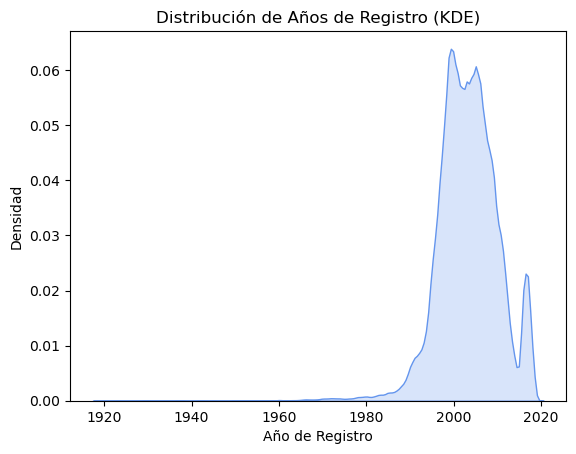

In [130]:
# Gráfico de densidad KDE
sns.kdeplot(df['registration_year'], fill=True, color='cornflowerblue')
plt.title('Distribución de Años de Registro (KDE)')
plt.xlabel('Año de Registro')
plt.ylabel('Densidad')
plt.show()

In [131]:
# Reducimos el rango de 1990 a 2020
df = df.loc[(df['registration_year']>1990) & (df['registration_year']<2020)]

**Brand**

In [132]:
# Total de Brands en %

# Calcular la frecuencia de cada marca
brand_counts = df['brand'].value_counts()

# Calcular el porcentaje de cada marca
brand_percentages = (brand_counts / len(df)) * 100
brand_percentages.head(10)

brand
volkswagen       21.607456
opel             11.454932
bmw              10.658244
mercedes_benz     9.032898
audi              8.551397
ford              7.253510
renault           5.190582
peugeot           3.122810
fiat              2.683937
seat              2.068741
Name: count, dtype: float64

In [133]:
# Seleccionaremos el top 10 para el entrenamiento del modelo 
top10_brands = ['volkswagen', 'opel', 'bmw', 'mercedes_benz', 'audi', 'ford', 'renault', 'peugeot', 'fiat', 'seat']

# Agrupar marcas que representan menos del 2% de la información cada una
df['brand'] = df['brand'].where(df['brand'].isin(top10_brands), 'other')

# Imprimir las categorías únicas de marcas ordenadas alfabéticamente
print(df['brand'].sort_values().unique())

['audi' 'bmw' 'fiat' 'ford' 'mercedes_benz' 'opel' 'other' 'peugeot'
 'renault' 'seat' 'volkswagen']


**Valores Numéricos**

**Price**

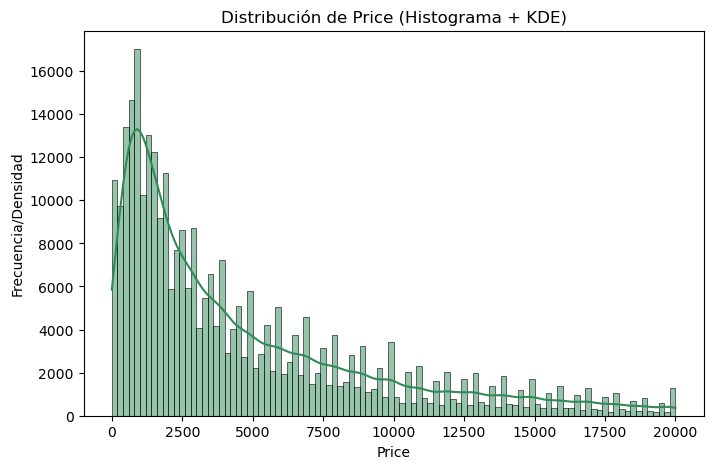

In [134]:
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], kde=True, bins=100, color='seagreen', edgecolor='black')
plt.title('Distribución de Price (Histograma + KDE)')
plt.xlabel('Price')
plt.ylabel('Frecuencia/Densidad')
plt.show()

Si un auto cuesta **menos de 60 € es más probable que sea un auto chatarra**. Vamos a eliminar los autos que tengan el precio menor a eso.

In [135]:
# Eliminar valores de 'price' menores a 60
df = df[df['price'] >= 60]

**Power**

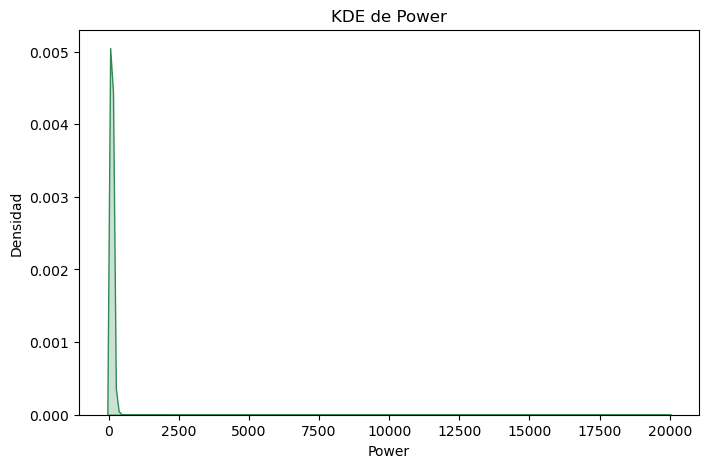

In [136]:
# Crear el gráfico KDE de la columna 'power'
plt.figure(figsize=(8, 5))
sns.kdeplot(df['power'], color='seagreen', fill=True)
plt.title('KDE de Power')
plt.xlabel('Power')
plt.ylabel('Densidad')
plt.show()

In [137]:
# Filtrar horsepower 
df = df[(df['power'] >= 30) & (df['power'] <= 350)]

**Mileage**

In [138]:
# Ver los valores más frecuentes
df['mileage'].value_counts().head(20)

mileage
150000    186069
125000     30425
100000     11998
90000       9769
80000       8524
70000       7335
60000       6445
50000       5363
40000       4221
30000       3634
20000       2976
5000        2195
10000        805
Name: count, dtype: int64

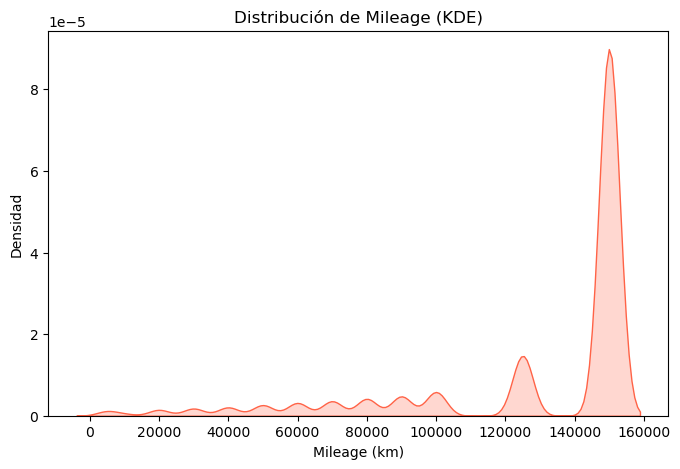

In [139]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df['mileage'], fill=True, color='tomato')
plt.title('Distribución de Mileage (KDE)')
plt.xlabel('Mileage (km)')
plt.ylabel('Densidad')
plt.show()

In [140]:
# Filtrar para mantener solo los valores de 'mileage' entre 20,000 y 150,000 km
df = df[(df['mileage'] >= 20000) & (df['mileage'] <= 150000)]

## Correlación de datos

In [141]:
# Calcular la correlación solo para columnas numéricas
corr_matrix = df.select_dtypes(include='number').corr()

# Mostrar la matriz de correlación
display(corr_matrix) 

,price,registration_year,power,mileage
price,1.000000,0.551514,0.520681,-0.424882
registration_year,0.551514,1.000000,0.112951,-0.392463
power,0.520681,0.112951,1.000000,0.095796
mileage,-0.424882,-0.392463,0.095796,1.000000


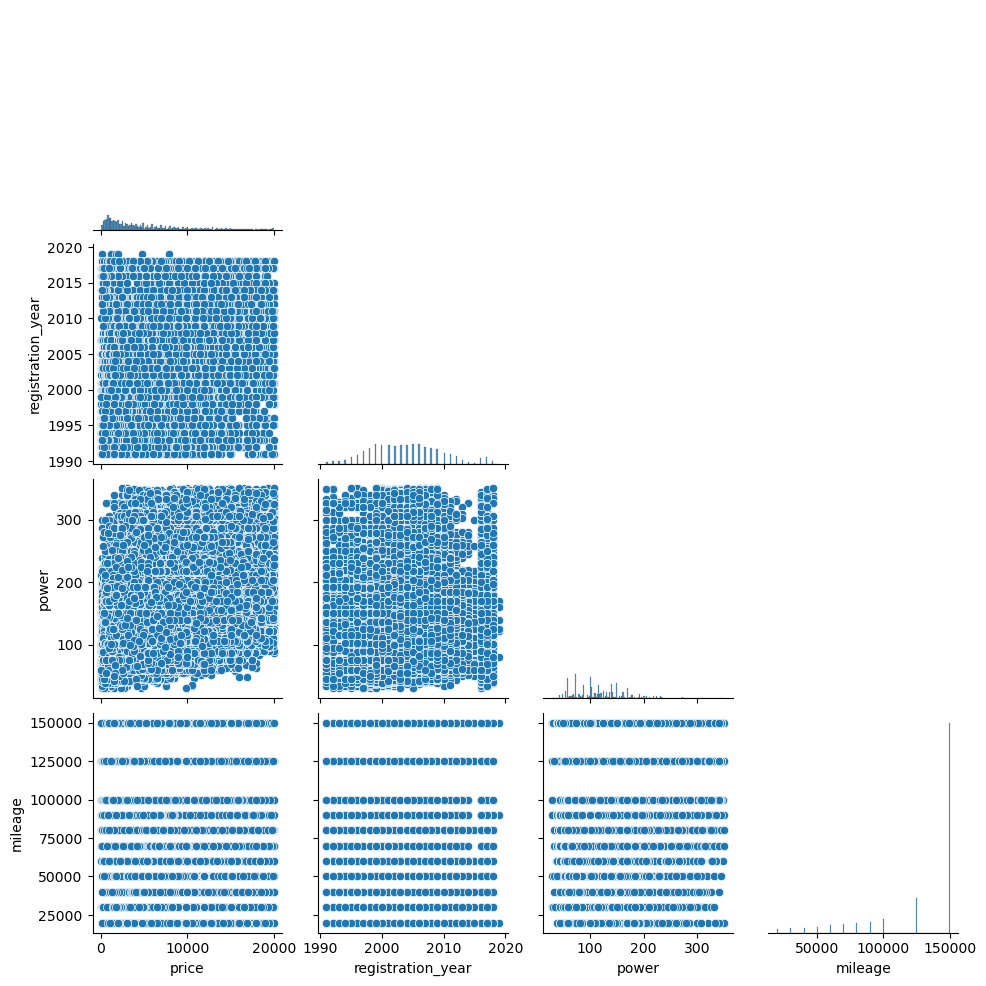

In [142]:
# Crear la matriz de dispersión de df_cleaned
sns.pairplot(df, corner=True)
plt.show()

**Puntos clave de Correlación**   

- **Precio y Año de Registro**: Los autos más nuevos suelen ser más caros.
- **Precio y Kilometraje**: Los autos con más kilometraje tienden a ser más baratos.
- **Potencia**: Tiene una relación débil con el precio y el kilometraje.
- **Año de Registro y Kilometraje**: Los autos más viejos suelen tener más kilometraje.

Los resultados son esperados conforme a la lógica de asignación de precios en la venta de autos.    
Ahora, continuamos con el entrenamiento de los modelos.   

In [143]:
# Copia del df para entrenar modelos
df_m = df.copy()

## Entrenamiento del modelo 

El conjunto de datos **df_cleaned** se dividirá en tres subconjuntos: **entrenamiento**, **validación** y **prueba**, siguiendo una **proporción de 60:20:20**. Para evaluar el rendimiento de los modelos, se empleará la métrica **RMSE (Root Mean Squared Error)**, junto con la **velocidad de ejecución** de cada modelo, lo que permitirá una comparación entre precisión y eficiencia.

Los modelos que se analizarán son los siguientes:

1. **Regresión Lineal**: Se utilizará como modelo base para establecer una línea de referencia y realizar una prueba de cordura.
2. **Árbol de Decisión**: Un modelo basado en divisiones sucesivas que permite capturar relaciones no lineales en los datos.
3. **Bosque Aleatorio**: Un enfoque de ensamble que combina múltiples árboles de decisión para mejorar la precisión y reducir el sobreajuste.
4. **LightGBM**: Un modelo de boosting optimizado para velocidad y rendimiento, ideal para conjuntos de datos grandes.
5. **CatBoost**: Un modelo de boosting especializado en el manejo eficiente de variables categóricas, con un enfoque en la robustez y precisión.
6. **XGBoost**: Un modelo de boosting ampliamente reconocido por su eficiencia y alto rendimiento en problemas de predicción.

Cada modelo será evaluado en términos de su **RMSE** y su **velocidad de ejecución**, lo que permitirá comparar su capacidad para predecir el valor de mercado de los vehículos de manera precisa y eficiente. Esta evaluación proporcionará una visión clara de las ventajas y desventajas de cada enfoque, facilitando la selección del modelo más adecuado para encontrar el precio adecuado de los autos.

In [144]:
# Separar el objetivo (target) y las características (features)
target = df_m['price'] 
features = df_m.drop(columns=['price']) 

In [145]:
# Separar entrenamiento 60% y el resto 40% para validación + prueba
features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.4, random_state=12345)

# Separar validación (50% de los datos restantes) y prueba (50% de los datos restantes)
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, random_state=12345)

# Verifica los tamaños de los conjuntos
print(f"Training set size: {features_train.shape[0]}")
print(f"Validation set size: {features_valid.shape[0]}")
print(f"Test set size: {features_test.shape[0]}")

Training set size: 166055
Validation set size: 55352
Test set size: 55352


In [146]:
# Aplicar One-Hot Encoding a las columnas categóricas
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)

In [147]:
# Función para calcular tiempo de entrenamiento y de predicciones
def train_and_pred_time(model, model_name, train_features, train_target, valid_features):
    # Tiempo antes del entrenamiento
    start_time1 = time.time()
    
    # Entrenar modelo
    if model_name == 'cbr':
        model.fit(train_features)
    else: 
        model.fit(train_features, train_target)
    
    end_time1 = time.time()    # Tiempo después del entrenamiento

    train_time = end_time1 - start_time1    # Duración del entrenamiento
    
    start_time2 = time.time()    # Tiempo antes de la predicción
    
    predictions = model.predict(valid_features)    # Predicción de datos de validación
   
    end_time2 = time.time()    # Tiempo después de la predicción

    pred_time = end_time2 - start_time2    # Duración de la predicción

    return train_time, pred_time, predictions

### 1. Regresión Lineal  


La **Regresión Lineal se usa como baseline** para comparar el rendimiento de modelos más avanzados.   
Sirve como punto de partida para medir si algoritmos más complejos realmente mejoran los resultados.    
Además, su simplicidad ayuda a entender cómo las variables influyen en la predicción.   

In [148]:
# 1. Modelo de Regresión Lineal
lr_model = LinearRegression()  # Inicializamos el modelo de regresión lineal

# Entrenamos el modelo y medimos el tiempo de entrenamiento y predicción
lr_train_time, lr_pred_time, lr_pred = train_and_pred_time(lr_model, 'lr', features_train_ohe, target_train, features_valid_ohe)

# Calculamos el RMSE en el conjunto de entrenamiento
lr_train_rmse = round(mean_squared_error(target_train, lr_model.predict(features_train_ohe)), 2)

# Calculamos el RMSE en el conjunto de validación
lr_valid_rmse = round(mean_squared_error(target_valid, lr_pred), 2)

# Imprimimos los resultados de error para evaluar el rendimiento del modelo
print('RMSE training set:   ', lr_train_rmse)  # Error en el conjunto de entrenamiento
print('RMSE validation set: ', lr_valid_rmse)  # Error en el conjunto de validación

RMSE training set:    6695606.73
RMSE validation set:  6649249.86


### 2. Árbol de Decisión  


In [149]:
# 2. Modelo Árbol de Decisión (Decision Tree Regressor)

# Definir los valores de hiperparámetros a evaluar
param_dist = {
    'max_depth': randint(1, 20),               # Profundidad máxima del árbol
    'min_samples_split': randint(2, 20),       # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': randint(1, 20),        # Mínimo de muestras en una hoja
    'max_features': ['sqrt', 'log2', None]     # Número de características a considerar en cada división
}

# Inicializar el modelo de árbol de decisión
tr_model = DecisionTreeRegressor(random_state=12345)

# Realizar una búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(
    estimator=tr_model,
    param_distributions=param_dist,
    n_iter=10,  # Número de combinaciones aleatorias a probar
    cv=5,       # Validación cruzada con 5 folds
    verbose=1,
    random_state=12345
)

# Entrenar el modelo con los datos de entrenamiento
random_search.fit(features_train_ohe, target_train)

# Obtener el mejor modelo encontrado
best_tree_model = random_search.best_estimator_

# Entrenar el modelo final con los mejores hiperparámetros
best_tree_model.fit(features_train_ohe, target_train)

# Calcular el RMSE en el conjunto de entrenamiento
train_pred = best_tree_model.predict(features_train_ohe)
train_rmse = round(mean_squared_error(target_train, train_pred) ** 0.5, 2)

# Calcular el RMSE en el conjunto de validación
valid_pred = best_tree_model.predict(features_valid_ohe)
valid_rmse = round(mean_squared_error(target_valid, valid_pred) ** 0.5, 2)


# Imprimir los resultados
print("Mejores hiperparámetros:", random_search.best_params_)
print('RMSE training set:   ', train_rmse)
print('RMSE validation set: ', valid_rmse)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores hiperparámetros: {'max_depth': 19, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 13}
RMSE training set:    1507.52
RMSE validation set:  1711.67


### 3. Bosque Aleatorio  


In [150]:
# 3. Modelo Bosque Aleatorio de Decisión (Random Forest Regressor)

# Definir los valores de hiperparámetros a evaluar
param_dist_rfr = {
    'n_estimators': randint(10, 200),          # Número de árboles en el bosque
    'max_depth': randint(1, 20),               # Profundidad máxima de cada árbol
    'min_samples_split': randint(2, 20),       # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': randint(1, 20),        # Mínimo de muestras en una hoja
    'max_features': ['sqrt', 'log2', None]     # Número de características a considerar en cada división
}

# Inicializar el modelo de Random Forest
rfr_model = RandomForestRegressor(random_state=12345)

# Realizar una búsqueda aleatoria de hiperparámetros
random_search_rfr = RandomizedSearchCV(
    estimator=rfr_model,
    param_distributions=param_dist_rfr,
    n_iter=10,  # Número de combinaciones aleatorias a probar
    cv=5,       # Validación cruzada con 5 folds
    verbose=1,
    random_state=12345
)

# Entrenar el modelo con los datos de entrenamiento
random_search_rfr.fit(features_train_ohe, target_train)

# Obtener el mejor modelo encontrado
best_rfr_model = random_search_rfr.best_estimator_

# Entrenar el modelo final con los mejores hiperparámetros
best_rfr_model.fit(features_train_ohe, target_train)

# Calcular el RMSE en el conjunto de entrenamiento
train_pred = best_rfr_model.predict(features_train_ohe)
train_rmse = round(mean_squared_error(target_train, train_pred) ** 0.5, 2)

# Calcular el RMSE en el conjunto de validación
valid_pred = best_rfr_model.predict(features_valid_ohe)
valid_rmse = round(mean_squared_error(target_valid, valid_pred) ** 0.5, 2)


# Imprimir los resultados
print("Mejores hiperparámetros:", random_search_rfr.best_params_)
print('RMSE training set:   ', train_rmse)
print('RMSE validation set: ', valid_rmse)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores hiperparámetros: {'max_depth': 14, 'max_features': None, 'min_samples_leaf': 18, 'min_samples_split': 8, 'n_estimators': 17}
RMSE training set:    1666.97
RMSE validation set:  1728.9


### 4. LightGBM  


In [151]:
# 4. LightGBM (Light Gradient Boosting Machine)

# Inicializamos el modelo LightGBM con hiperparámetros predeterminados
ltb1_model = ltb.LGBMRegressor(
    boosting_type='gbdt',   # Tipo de boosting (Gradient Boosting Decision Tree)
    num_leaves=31,          # Número máximo de hojas en cada árbol
    max_depth=-1,           # Sin restricción de profundidad
    learning_rate=0.1,      # Tasa de aprendizaje
    n_estimators=100        # Número total de árboles en el modelo
)

# Entrenamos el modelo y medimos el tiempo de entrenamiento y predicción
ltb_train_time1, ltb_pred_time1, ltb_pred1 = train_and_pred_time(ltb1_model, 'ltb', features_train_ohe, target_train, features_valid_ohe)

# Calculamos el RMSE en el conjunto de entrenamiento
ltb1_train_rmse = round(mean_squared_error(target_train, ltb1_model.predict(features_train_ohe)), 2)

# Calculamos el RMSE en el conjunto de validación
ltb1_valid_rmse = round(mean_squared_error(target_valid, ltb_pred1), 2)

# Imprimimos los resultados de error para evaluar el rendimiento del modelo
print('RMSE training set:   ', ltb1_train_rmse)  # Error en el conjunto de entrenamiento
print('RMSE validation set: ', ltb1_valid_rmse)  # Error en el conjunto de validación

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 275
[LightGBM] [Info] Number of data points in the train set: 166055, number of used features: 26
[LightGBM] [Info] Start training from score 4880.962591
RMSE training set:    2739026.87
RMSE validation set:  2772998.72


### 5. CatBoost  


In [152]:
# 5. CatBoost (Categorical Boosting)

# Definimos los índices de las características categóricas en los datos de entrenamiento
categorical_features_indices = [0, 2, 5, 6, 7]

# Creamos el conjunto de datos de entrenamiento especificando las características categóricas
train_data = Pool(data=features_train, label=target_train, cat_features=categorical_features_indices)

# Inicializamos el modelo CatBoost con hiperparámetros básicos
cbr_model = CatBoostRegressor(
    iterations=500,                # Número de iteraciones (árboles) que el modelo va a construir
    learning_rate=0.03,            # Tasa de aprendizaje que controla la influencia de cada árbol en el modelo final
    depth=6,                       # Profundidad máxima de los árboles de decisión
    l2_leaf_reg=3,                 # Regularización L2 para prevenir el sobreajuste en las hojas de los árboles
    random_seed=123456,            # Semilla aleatoria para asegurar resultados reproducibles
    verbose=False,                 # Desactivamos la salida de información sobre el entrenamiento
    early_stopping_rounds=50       # Número de rondas sin mejora en el conjunto de validación para detener el entrenamiento antes de las 500 iteraciones
)


# Entrenamos el modelo y medimos el tiempo de entrenamiento y predicción
cbr_train_time, cbr_pred_time, cbr_pred = train_and_pred_time(cbr_model, 'cbr', train_data, target_train, features_valid)

# Calculamos el RMSE en el conjunto de entrenamiento
cbr_train_rmse = round(mean_squared_error(target_train, cbr_model.predict(features_train)), 2)

# Calculamos el RMSE en el conjunto de validación
cbr_valid_rmse = round(mean_squared_error(target_valid, cbr_model.predict(features_valid)), 2)

# Imprimimos los resultados de error para evaluar el rendimiento del modelo
print('RMSE training set:   ', cbr_train_rmse)  # Error en el conjunto de entrenamiento
print('RMSE validation set: ', cbr_valid_rmse)  # Error en el conjunto de validación

RMSE training set:    2849918.37
RMSE validation set:  2856442.84


### 6. XGBoost

In [153]:
# 6. XGBoost (Extreme Gradient Boosting)

# Inicializamos el modelo XGBoost con hiperparámetros específicos
xgbr_model = xg.XGBRegressor(
    booster='gbtree',              # Tipo de booster (modelo base), 'gbtree' significa que se usarán árboles de decisión
    objective='reg:squarederror',  # Objetivo de la función de pérdida, en este caso, el error cuadrático medio (MSE)
    n_estimators=200,              # Número de árboles a construir (estimadores)
    max_depth=6,                   # Profundidad máxima de cada árbol. Valores más altos permiten modelos más complejos
    learning_rate=0.05,            # Tasa de aprendizaje, controla el tamaño del paso en cada iteración
    reg_lambda=3,                  # Regularización L2 (Ridge), ayuda a evitar el sobreajuste al penalizar grandes coeficientes
    reg_alpha=1,                   # Regularización L1 (Lasso), también ayuda a evitar el sobreajuste, promoviendo la sparsidad en los coeficientes
    seed=12345                     # Semilla aleatoria para asegurar que los resultados sean reproducibles
)


# Entrenamos el modelo y medimos el tiempo de entrenamiento y predicción
xgbr_train_time1, xgbr_pred_time1, xgbr_pred1 = train_and_pred_time(xgbr1_model, 'xgbr', features_train_ohe, target_train, features_valid_ohe)

# Calculamos el RMSE en el conjunto de entrenamiento
xgbr_train_rmse1 = round(mean_squared_error(target_train, xgbr1_model.predict(features_train_ohe)), 2)

# Calculamos el RMSE en el conjunto de validación
xgbr_valid_rmse1 = round(mean_squared_error(target_valid, xgbr1_model.predict(features_valid_ohe)), 2)

# Imprimimos los resultados de error para evaluar el rendimiento del modelo
print('RMSE training set:   ', xgbr_train_rmse1)  # Error en el conjunto de entrenamiento
print('RMSE validation set: ', xgbr_valid_rmse1)  # Error en el conjunto de validación

RMSE training set:    9387592.0
RMSE validation set:  9311836.0


## Selección del modelo

**Comparación de resultados:**

In [154]:
# Comparación de modelos
table = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree Regressor', 'Random Forest Regressor', 'LGBM Regressor', 'CatBoost Regressor', 'XGB Regressor'],
    'Training_time_s': [lr_train_time, dtr_train_time, rfr_train_time, ltb_train_time1, cbr_train_time, xgbr_train_time1],
    'Prediction_time_ms': [lr_pred_time, dtr_pred_time, rfr_pred_time, ltb_pred_time1, cbr_pred_time, xgbr_pred_time1],
    'RMSE_training_set': [lr_train_rmse, dtr_train_rmse, rfr_train_rmse, ltb1_train_rmse, cbr_train_rmse, xgbr_train_rmse1],
    'RMSE_validation_set': [lr_valid_rmse, dtr_valid_rmse, rfr_valid_rmse, ltb1_valid_rmse, cbr_valid_rmse, xgbr_valid_rmse1]
})

# Imprimir tabla
table.sort_values('Training_time_s')

,Model,Training_time_s,Prediction_time_ms,RMSE_training_set,RMSE_validation_set
0,Linear Regression,0.062756,0.003318,6695606.73,6649249.86
3,LGBM Regressor,0.185049,0.044662,2739026.87,2772998.72
1,Decision Tree Regressor,0.233892,0.006178,2078085.94,3265271.71
5,XGB Regressor,0.238368,0.010614,9387592.00,9311836.00
2,Random Forest Regressor,0.288395,0.021819,4495081.91,4522976.68
4,CatBoost Regressor,6.349245,0.019448,2849918.37,2856442.84


**Selección del mejor modelo**

Tras evaluar varios modelos, utilizando **Linear Regression** como baseline para comparar el rendimiento, determinamos que **LGBM Regressor** ofrece un excelente equilibrio entre precisión y velocidad. El baseline de **Linear Regression** muestra un tiempo de entrenamiento bajo (0.066s) y predicción rápida (0.005ms), pero su RMSE es significativamente alto (6,649,249.86 en validación), lo que indica que modelos más sofisticados son necesarios.

**LGBM Regressor** destaca con un tiempo de entrenamiento eficiente (0.275s), predicción rápida (0.049ms) y una precisión notablemente superior al baseline (RMSE validación: 2,772,998.72). **CatBoost Regressor** muestra resultados similares en precisión (RMSE validación: 2,856,442.84), pero requiere mucho más tiempo de entrenamiento (6.455s).

El RMSE (Root Mean Squared Error) nos ayuda a medir el error promedio en las predicciones. Comparando con el baseline de **Linear Regression**, tanto **LGBM** como **CatBoost** reducen el error en más de un 58%, lo que representa una mejora sustancial en la precisión de las predicciones.

**LGBM Regressor** cumple efectivamente con los objetivos de **Rusty Bargain**:

- **Predicción precisa**: Mejora significativamente la precisión respecto al baseline, reduciendo el RMSE en más de la mitad.
- **Respuesta rápida**: Su velocidad de predicción es solo 0.044ms más lenta que el baseline, manteniendo una respuesta prácticamente instantánea.
- **Eficiencia en entrenamiento**: Aunque es 0.209s más lento que el baseline en entrenamiento, el tiempo sigue siendo muy eficiente y la mejora en precisión justifica esta pequeña diferencia.

Esta selección permitirá que la aplicación ofrezca valoraciones rápidas y significativamente más precisas que el modelo baseline, mejorando la experiencia del usuario y potenciando la atracción de nuevos clientes.
